### Imports.

In [1]:
# Numpy
import numpy as np
import pandas as pd
%matplotlib nbagg
import matplotlib.pyplot as plt
import scipy.stats

# Machine learning
import tensorflow as tf
import keras
import sklearn
import sklearn.preprocessing, sklearn.base, sklearn.utils, sklearn.model_selection

# Various Python tricks and libraries
import requests
import time
import functools
import operator
import collections
from tqdm import tqdm, tqdm_notebook, trange
import dill as pickle
import IPython

# Parallel
import joblib

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# (initial effort,) jobs.end > now - 1day

In [2]:
jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown','kijana','root'])

Clean data.

In [3]:
jobs = jobs.dropna() # remove bombs
jobs[['Submit', 'Start', 'End']] = jobs[['Submit', 'Start', 'End']].apply(pd.to_datetime)
jobs['NNodes'] = pd.to_numeric(jobs['NNodes'], errors='coerce', downcast='integer')
jobs['Timelimit'] = jobs['Timelimit'].str.replace('-','day ')
jobs['Timelimit'] = pd.to_timedelta(jobs['Timelimit'], errors='coerce')
jobs['Wait'] = (jobs['Start'] - jobs['Submit']) / pd.Timedelta('1h')
jobs = jobs[(np.abs(scipy.stats.zscore(jobs['Wait'])) <3)]
jobs = jobs.dropna()

Prepare for ML.

In [ ]:
# A parallelized version.
valid_jobs = jobs[jobs['Submit'] > jobs['End'].min()].copy()
# L = []

# for idx in tqdm_notebook(valid_jobs.index):
def func(idx, jobs=jobs):

    tj = this_job = (jobs.loc[idx]).copy()
    now = tj['Submit']
    rj = relevant_jobs = jobs.loc[np.logical_and(jobs['Submit'] < now, jobs['End'] > now - pd.Timedelta('1day'))].copy()
    if len(rj) == 0:
        return None
        # continue
    
    J = rj['NNodes']
    E = rj['Timelimit'] / pd.Timedelta('1h')
    # let's expand R into R1, R2 and R3 and such.
    # status: i) finished, ii) running, iii) queueing
    # value:  i) wait_time, runtime, ii) run time so far, iii) queue time so far
    is_finished = rj['End'] < now
    is_running = np.logical_and(rj['End'] >= now, rj['Start'] < now)
    is_queueing = rj['Start'] >= now
    wait_time = (rj['Start'] - rj['Submit']) / pd.Timedelta('1h') * (is_finished + is_running)
    run_time = (rj['End'] - rj['Start']) / pd.Timedelta('1h') * is_finished
    run_time_so_far = (now - rj['Start']) / pd.Timedelta('1h') * is_running
    queue_time_so_far = (now - rj['Submit']) / pd.Timedelta('1h') * is_queueing
    
    U = rj['User']
    
    thisJ = tj['NNodes']
    thisE = tj['Timelimit'] / pd.Timedelta('1h')
    thisU = tj['User']
    thisW = (tj['Start'] - tj['Submit']) / pd.Timedelta('1h')
    
    # JER = np.stack((J.values, E.values, run_time_so_far.values), axis=-1)
    JER = np.stack((J.values, E.values, is_finished.values, is_running.values, is_queueing.values, wait_time.values, run_time.values, run_time_so_far.values, queue_time_so_far.values), axis=-1)
    thisJE = [thisJ, thisE]
    return [JER, U.values, thisJE, thisU, thisW]
    # L.append([JER, U.values, thisJE, thisU, thisW])

L = joblib.Parallel(n_jobs=20)(joblib.delayed(func)(idx) for idx in tqdm_notebook(valid_jobs.index))
# L = [func(idx) for idx in valid_jobs.index]
L = [_ for _ in L if _]
JERs_, Us_, thisJEs_, thisUs_, thisWs_ = zip(*L)


In [5]:
# scale / label
JERscaler = sklearn.preprocessing.StandardScaler()
JERscaler.fit(np.concatenate(JERs_, axis=0))
JERs_scaled = [JERscaler.transform(_) for _ in JERs_]

In [6]:
Ule = sklearn.preprocessing.LabelEncoder()
Ule.fit(np.concatenate(Us_, axis=0))
Us_labeled = [Ule.transform(_) for _ in Us_]

In [7]:
thisJEs_scaled = sklearn.preprocessing.StandardScaler().fit_transform(thisJEs_)

In [8]:
thisUs_labeled = Ule.transform(thisUs_)

In [9]:
thisWs_scaled = sklearn.preprocessing.StandardScaler().fit_transform(np.array(thisWs_).reshape(-1,1))

In [10]:
# pad sequence
Lens_ = [len(_) for _ in Us_]
JERs_padded = keras.preprocessing.sequence.pad_sequences(JERs_scaled)
Us_padded = keras.preprocessing.sequence.pad_sequences(Us_labeled)

In [11]:
# convert to numpy
JERs_final, Us_final, thisJEs_final, thisUs_final, thisWs_final, Lens_final = map(
    np.array,
    [JERs_padded, Us_padded, thisJEs_scaled, thisUs_labeled, thisWs_scaled, Lens_]
)

In [12]:
# other
N_SAMPLES = len(Us_final)
print N_SAMPLES
VOC_SIZE_U = np.amax(Us_final) + 1

13130


Build a model and train.

<IPython.core.display.Javascript object>


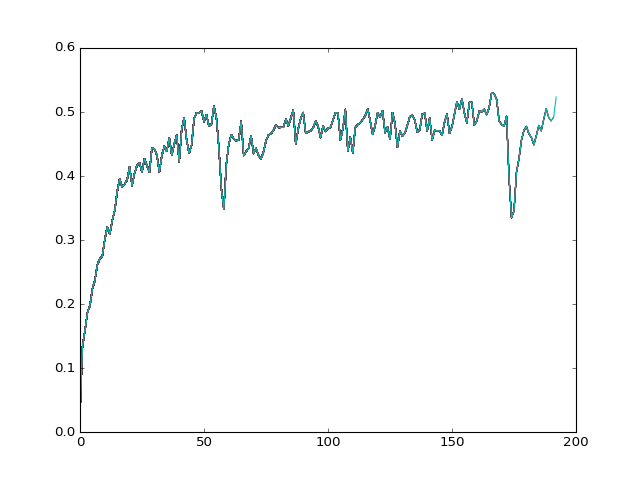

HBox(children=(IntProgress(value=0, max=1923), HTML(value=u'')))

In [13]:
# Graph
N_EPOCHS = 150
BATCH_SIZE = 1024
r2s = []
fig, ax = plt.subplots(1,1)
tf.reset_default_graph()

JER = tf.placeholder(name="JER", dtype=tf.float32, shape=(None, None, 9))
U_id = tf.placeholder(name="U_id", dtype=tf.int32, shape=(None, None))
thisJE = tf.placeholder(name="thisJE", dtype=tf.float32, shape=(None, 2))
thisU_id = tf.placeholder(name="thisU_id", dtype=tf.int32, shape=(None))
thisW = tf.placeholder(name="thisW", dtype=tf.float32, shape=(None, 1))
Lens = tf.placeholder(name="Lens", dtype=tf.int32, shape=(None))

U_embeddings = tf.get_variable(name="U_embeddings", shape=[VOC_SIZE_U, 3])
U = tf.nn.embedding_lookup(U_embeddings, U_id)

thisU_embeddings = tf.get_variable(name="thisU_embeddings", shape=[VOC_SIZE_U, 3])
thisU = tf.nn.embedding_lookup(thisU_embeddings, thisU_id)

thisJE_tiled = tf.tile(tf.expand_dims(thisJE, axis=1), multiples=(1,tf.shape(JER)[1],1))
thisU_tiled = tf.tile(tf.expand_dims(thisU, axis=1), multiples=(1,tf.shape(JER)[1],1))
X = tf.concat([JER, U, thisJE_tiled, thisU_tiled], axis=-1)
X.set_shape([None, None, 17])
hs, h = tf.nn.dynamic_rnn(tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(45), tf.contrib.rnn.GRUCell(35)]),
                            X,
                            dtype=tf.float32,
                            sequence_length=Lens)
thisWhat = tf.layers.dense(h[1], units=1, activation=None)

loss = tf.reduce_mean(tf.square(thisWhat - thisW), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)
# training_op = tf.train.MomentumOptimizer(learning_rate=1E-2, momentum=0.91, use_nesterov=True).minimize(loss)

# Session
sess = tf.Session()
sess.run(tf.global_variables_initializer())
t = tqdm_notebook(range(N_EPOCHS * N_SAMPLES / BATCH_SIZE), leave=True)
for epoch in t:
    index = np.random.choice(range(N_SAMPLES), BATCH_SIZE, replace=False)
    sess.run(training_op, 
             feed_dict = {
                 JER: JERs_final[index],
                 U_id: Us_final[index],
                 thisJE: thisJEs_final[index],
                 thisU_id: thisUs_final[index],
                 thisW: thisWs_final[index],
                 Lens: Lens_final[index]
             })
    if epoch % 10 == 1:
        thisWhat_ = sess.run(thisWhat, 
                             feed_dict = {
                                 JER: JERs_final,
                                 U_id: Us_final,
                                 thisJE: thisJEs_final,
                                 thisU_id: thisUs_final,
                                 thisW: thisWs_final,
                                 Lens: Lens_final
                             })
        r2 = sklearn.metrics.r2_score(thisWs_final, thisWhat_)
        r2s.append(r2)
        t.set_description(str(r2))
        ax.plot(r2s)
        fig.canvas.draw()
        fig.canvas.show()

<IPython.core.display.Javascript object>


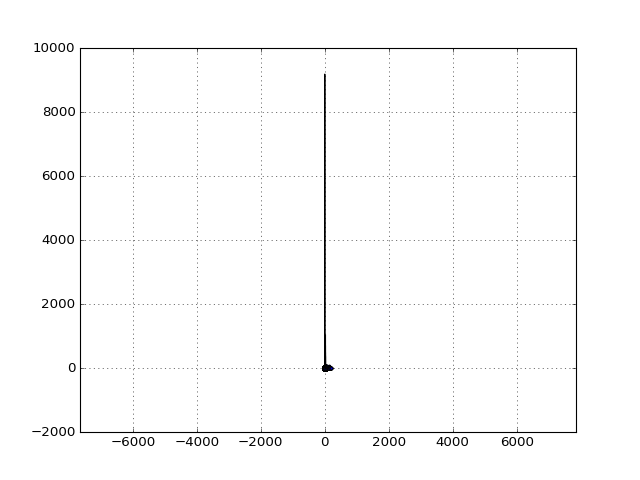

In [14]:
fig2, ax2 = plt.subplots(1,1)
ax2.axis('equal')
ax2.scatter(thisWs_final, thisWhat_, s=1, alpha=0.5)
fig2.canvas.draw()
fig2.canvas.show()

In [15]:
jobs['Wait'].hist(bins=20)

# More history?

In [36]:
jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown','kijana','root'])

Clean data.

In [37]:
jobs = jobs.dropna() # remove bombs
jobs[['Submit', 'Start', 'End']] = jobs[['Submit', 'Start', 'End']].apply(pd.to_datetime)
jobs['NNodes'] = pd.to_numeric(jobs['NNodes'], errors='coerce', downcast='integer')
jobs['Timelimit'] = jobs['Timelimit'].str.replace('-','day ')
jobs['Timelimit'] = pd.to_timedelta(jobs['Timelimit'], errors='coerce')
jobs['Wait'] = (jobs['Start'] - jobs['Submit']) / pd.Timedelta('1h')
jobs = jobs[(np.abs(scipy.stats.zscore(jobs['Wait'])) <3)]
jobs = jobs.dropna()

Prepare for ML.

In [38]:
# A parallelized version.
valid_jobs = jobs[jobs['Submit'] > jobs['End'].min()].copy()
# L = []

# for idx in tqdm_notebook(valid_jobs.index):
def func(idx, jobs=jobs):

    tj = this_job = (jobs.loc[idx]).copy()
    now = tj['Submit']
    rj = relevant_jobs = jobs.loc[np.logical_and(jobs['Submit'] < now, jobs['End'] > now - pd.Timedelta('7day'))].copy()
    if len(rj) == 0:
        return None
        # continue
    
    J = rj['NNodes']
    E = rj['Timelimit'] / pd.Timedelta('1h')
    # let's expand R into R1, R2 and R3 and such.
    # status: i) finished, ii) running, iii) queueing
    # value:  i) wait_time, runtime, ii) run time so far, iii) queue time so far
    is_finished = rj['End'] < now
    is_running = np.logical_and(rj['End'] >= now, rj['Start'] < now)
    is_queueing = rj['Start'] >= now
    wait_time = (rj['Start'] - rj['Submit']) / pd.Timedelta('1h') * (is_finished + is_running)
    run_time = (rj['End'] - rj['Start']) / pd.Timedelta('1h') * is_finished
    run_time_so_far = (now - rj['Start']) / pd.Timedelta('1h') * is_running
    queue_time_so_far = (now - rj['Submit']) / pd.Timedelta('1h') * is_queueing
    
    U = rj['User']
    
    thisJ = tj['NNodes']
    thisE = tj['Timelimit'] / pd.Timedelta('1h')
    thisU = tj['User']
    thisW = (tj['Start'] - tj['Submit']) / pd.Timedelta('1h')
    
    # JER = np.stack((J.values, E.values, run_time_so_far.values), axis=-1)
    JER = np.stack((J.values, E.values, is_finished.values, is_running.values, is_queueing.values, wait_time.values, run_time.values, run_time_so_far.values, queue_time_so_far.values), axis=-1)
    thisJE = [thisJ, thisE]
    return [JER, U.values, thisJE, thisU, thisW]
    # L.append([JER, U.values, thisJE, thisU, thisW])

L = joblib.Parallel(n_jobs=20)(joblib.delayed(func)(idx) for idx in tqdm_notebook(valid_jobs.index))
# L = [func(idx) for idx in valid_jobs.index]
L = [_ for _ in L if _]
JERs_, Us_, thisJEs_, thisUs_, thisWs_ = zip(*L)


HBox(children=(IntProgress(value=0, max=13133), HTML(value=u'')))

/home/xzhang1/.local/lib/python2.7/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/home/xzhang1/.local/lib/python2.7/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/home/xzhang1/.local/lib/python2.7/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/home/xzhang1/.local/lib/python2.7/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexp

In [39]:
# scale / label
JERscaler = sklearn.preprocessing.StandardScaler()
JERscaler.fit(np.concatenate(JERs_, axis=0))
JERs_scaled = [JERscaler.transform(_) for _ in JERs_]

In [40]:
Ule = sklearn.preprocessing.LabelEncoder()
Ule.fit(np.concatenate(Us_, axis=0))
Us_labeled = [Ule.transform(_) for _ in Us_]

In [41]:
thisJEs_scaled = sklearn.preprocessing.StandardScaler().fit_transform(thisJEs_)

In [42]:
thisUs_labeled = Ule.transform(thisUs_)

In [43]:
thisWs_scaled = sklearn.preprocessing.StandardScaler().fit_transform(np.array(thisWs_).reshape(-1,1))

In [44]:
# pad sequence
Lens_ = [len(_) for _ in Us_]
JERs_padded = keras.preprocessing.sequence.pad_sequences(JERs_scaled)
Us_padded = keras.preprocessing.sequence.pad_sequences(Us_labeled)

In [45]:
# convert to numpy
JERs_final, Us_final, thisJEs_final, thisUs_final, thisWs_final, Lens_final = map(
    np.array,
    [JERs_padded, Us_padded, thisJEs_scaled, thisUs_labeled, thisWs_scaled, Lens_]
)

In [46]:
# other
N_SAMPLES = len(Us_final)
print N_SAMPLES
VOC_SIZE_U = np.amax(Us_final) + 1

13133


Build a model and train.

<IPython.core.display.Javascript object>


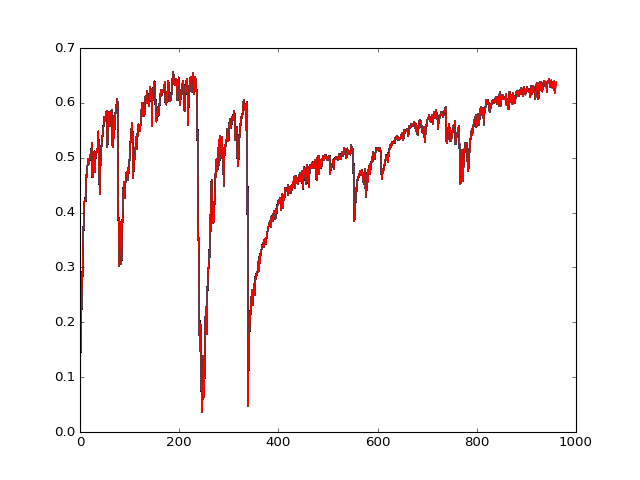

HBox(children=(IntProgress(value=0, max=9618), HTML(value=u'')))

In [47]:
# Graph
N_EPOCHS = 750
BATCH_SIZE = 1024
r2s = []
fig, ax = plt.subplots(1,1)
tf.reset_default_graph()

JER = tf.placeholder(name="JER", dtype=tf.float32, shape=(None, None, 9))
U_id = tf.placeholder(name="U_id", dtype=tf.int32, shape=(None, None))
thisJE = tf.placeholder(name="thisJE", dtype=tf.float32, shape=(None, 2))
thisU_id = tf.placeholder(name="thisU_id", dtype=tf.int32, shape=(None))
thisW = tf.placeholder(name="thisW", dtype=tf.float32, shape=(None, 1))
Lens = tf.placeholder(name="Lens", dtype=tf.int32, shape=(None))

U_embeddings = tf.get_variable(name="U_embeddings", shape=[VOC_SIZE_U, 3])
U = tf.nn.embedding_lookup(U_embeddings, U_id)

thisU_embeddings = tf.get_variable(name="thisU_embeddings", shape=[VOC_SIZE_U, 3])
thisU = tf.nn.embedding_lookup(thisU_embeddings, thisU_id)

thisJE_tiled = tf.tile(tf.expand_dims(thisJE, axis=1), multiples=(1,tf.shape(JER)[1],1))
thisU_tiled = tf.tile(tf.expand_dims(thisU, axis=1), multiples=(1,tf.shape(JER)[1],1))
X = tf.concat([JER, U, thisJE_tiled, thisU_tiled], axis=-1)
X.set_shape([None, None, 17])
hs, h = tf.nn.dynamic_rnn(tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(45), tf.contrib.rnn.GRUCell(35)]),
                            X,
                            dtype=tf.float32,
                            sequence_length=Lens)
h = tf.layers.dense(h[1], units=30, activation=tf.nn.elu)
thisWhat = tf.layers.dense(h, units=1, activation=None)

loss = tf.reduce_mean(tf.square(thisWhat - thisW), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)
# training_op = tf.train.MomentumOptimizer(learning_rate=1E-2, momentum=0.91, use_nesterov=True).minimize(loss)

# Session
sess = tf.Session()
sess.run(tf.global_variables_initializer())
t = tqdm_notebook(range(N_EPOCHS * N_SAMPLES / BATCH_SIZE), leave=True)
for epoch in t:
    index = np.random.choice(range(N_SAMPLES), BATCH_SIZE, replace=False)
    sess.run(training_op, 
             feed_dict = {
                 JER: JERs_final[index],
                 U_id: Us_final[index],
                 thisJE: thisJEs_final[index],
                 thisU_id: thisUs_final[index],
                 thisW: thisWs_final[index],
                 Lens: Lens_final[index]
             })
    if epoch % 10 == 1:
        thisWhat_ = sess.run(thisWhat, 
                             feed_dict = {
                                 JER: JERs_final,
                                 U_id: Us_final,
                                 thisJE: thisJEs_final,
                                 thisU_id: thisUs_final,
                                 thisW: thisWs_final,
                                 Lens: Lens_final
                             })
        r2 = sklearn.metrics.r2_score(thisWs_final, thisWhat_)
        r2s.append(r2)
        t.set_description(str(r2))
        ax.plot(r2s)
        fig.canvas.draw()
        fig.canvas.show()

<IPython.core.display.Javascript object>


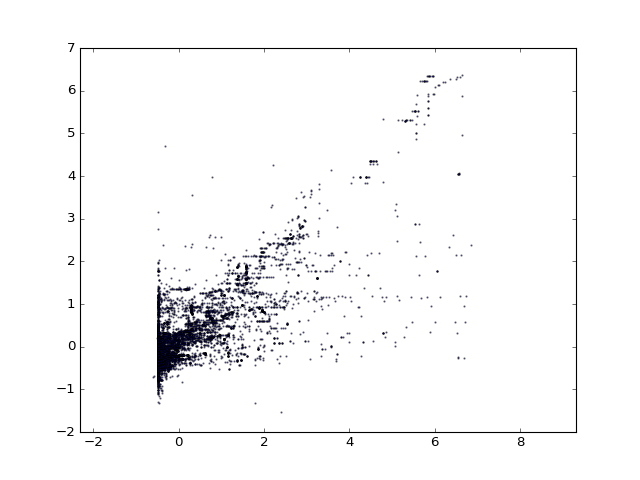

In [50]:
fig2, ax2 = plt.subplots(1,1)
ax2.axis('equal')
ax2.scatter(thisWs_final, thisWhat_, s=1, alpha=0.5)
fig2.canvas.draw()
fig2.canvas.show()

In [ ]:
jobs['Wait'].hist(bins=20)

In [ ]:
tf.train.Saver().save(sess, './ml_queue_7day_eachJob1GRU.ckpt')

# W.T.F.? Why such low accuracy? Queue length should be good enough.

In [ ]:
X = []
y = []
for i in tqdm_notebook(valid_jobs.index):
    now = jobs.loc[i,'Submit']
    running_jobs = jobs.loc[np.logical_and(jobs['Start'] < now, jobs['End'] > now)]
    n_running_jobs = len(running_jobs)
    queueing_jobs = jobs.loc[np.logical_and(jobs['Submit'] < now, jobs['Start'] > now)]
    n_queueing_jobs = len(queueing_jobs)
    if n_running_jobs + n_queueing_jobs == 0:
        continue
    noneself_jobs = jobs.loc[np.logical_and(np.logical_and(jobs['Submit'] < now, jobs['End'] > now), jobs['User']!=jobs.loc[i,'User'])]
    n_noneself_jobs = len(noneself_jobs)
    n_free_nodes = 31 - np.sum(running_jobs['NNodes'])
    n_requested_nodes = jobs.loc[i, 'NNodes']
    wait = jobs.loc[i, 'Wait']
    X.append([n_running_jobs, n_queueing_jobs, n_noneself_jobs, n_free_nodes, n_requested_nodes])
    y.append(wait)


In [ ]:
X = sklearn.preprocessing.MinMaxScaler(feature_range=[0,1]).fit_transform(X)
y = sklearn.preprocessing.MinMaxScaler(feature_range=[0,1]).fit_transform(np.c_[y])

model = keras.Sequential([
    keras.layers.Dense(input_shape=[5], units=56, activation='tanh'),
    keras.layers.Dense(units=16, activation='tanh'),
    keras.layers.Dense(units=1, activation=None)
])
model.compile(loss='mse', optimizer='adam')
model.fit(X, y, batch_size=128, epochs=100)

<IPython.core.display.Javascript object>


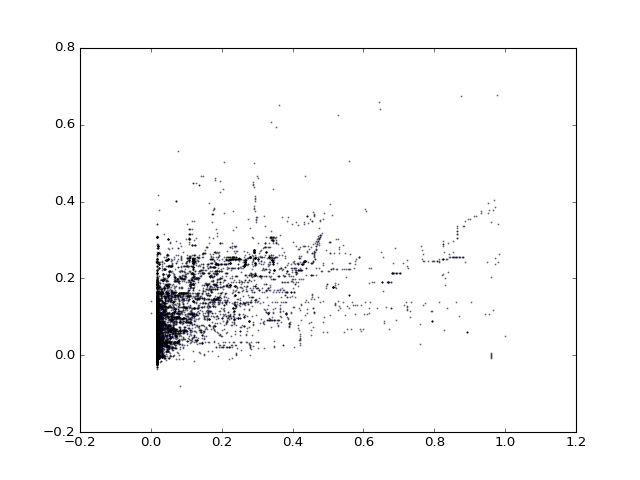

In [35]:
yhat = model.predict(X)
plt.scatter(y.reshape(-1), yhat.reshape(-1), s=0.5, alpha=0.5)
plt.show()

In [19]:
sklearn.metrics.r2_score(y.reshape(-1), yhat.reshape(-1))

0.33253982703518425

Conclusion: No. Queue length alone gives you $R^2=0.31$.

# As a time series? (Why the fuck does this work?)

Get data.

In [227]:
jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown','kijana','root']).dropna()

jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')

jobs.loc[:, 'Wait'] = jobs.loc[:, 'Start'] - jobs.loc[:, 'Submit']

jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
jobs = jobs.dropna()

Prepare data for ML.

In [228]:
jobs.loc[:, 'User'] = sklearn.preprocessing.LabelEncoder().fit_transform(jobs.loc[:, 'User'].copy())

In [229]:
jobs.loc[:, ['Wait', 'Timelimit']] = jobs.loc[:, ['Wait', 'Timelimit']].copy().values / pd.Timedelta('10h') # convert to number

In [230]:
jobs.loc[:, ['Wait', 'Timelimit', 'NNodes']] = sklearn.preprocessing.scale(jobs.loc[:, ['Wait', 'Timelimit', 'NNodes']].copy().values)

In [231]:
TIMESTEPS = 50
U_, X_, y_ = [[] for _ in range(3)]

for i in tqdm_notebook(range(TIMESTEPS, len(jobs))):
    
    tj = thisjob = jobs.iloc[i].copy()
    rj = related = jobs.iloc[i-TIMESTEPS:i+1].copy()
    
    U_.append(rj.loc[:, 'User'].copy().values) # [TIMESTEPS]
    
    rj.loc[:, 'Submit'] = (rj.loc[:, 'Submit'] - rj.iloc[0, 3]) / pd.Timedelta('10h')
    X_.append(rj.loc[:, ['NNodes', 'Timelimit', 'Submit']].copy().values) # [TIMESTEPS, 3]
    
    y_.append(rj.loc[:, ['Wait']].copy().values) # [TIMESTEPS, 1]

HBox(children=(IntProgress(value=0, max=13084), HTML(value=u'')))

In [232]:
U_ = np.int32(U_)
X_ = np.float32(X_)
y_ = np.float32(y_)

Select model and train.

<IPython.core.display.Javascript object>


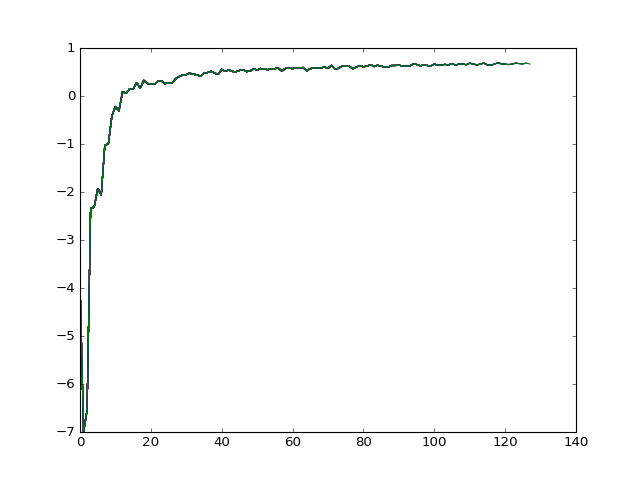

HBox(children=(IntProgress(value=0, max=1277), HTML(value=u'')))

In [234]:
# graph
U_VOCABULARY_SIZE = np.amax(U_)
N_EPOCHS = 100
BATCH_SIZE = 1024
N_SAMPLES = len(U_)

r2s = []
fig, ax = plt.subplots(1,1)
ax.set_ybound([-1,1])
tf.reset_default_graph()

U_id = tf.placeholder(name="U_id", dtype=tf.int32, shape=(None, None))
U_embeddings = tf.get_variable(name="U_embeddings", shape=[U_VOCABULARY_SIZE, 3])
U = tf.nn.embedding_lookup(U_embeddings, U_id, name="U")

X = tf.placeholder(name="X", dtype=tf.float32, shape=(None, None, 3))
XU = tf.concat([X,U], axis=-1, name="XU")
XU.set_shape([None, None, 6])

y = tf.placeholder(name="y", dtype=tf.float32, shape=(None, None, 1))

h1s, h1 = tf.nn.dynamic_rnn(tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(45), tf.contrib.rnn.GRUCell(35)]), XU, dtype=tf.float32)

h2 = tf.layers.dense(h1s, units=25, activation=tf.tanh, name="h2")
yhat = tf.layers.dense(h2, units=1, activation=None, name="yhat")

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

# sess
sess = tf.Session()
sess.run(tf.global_variables_initializer())
t = tqdm_notebook(range(N_EPOCHS * N_SAMPLES / BATCH_SIZE))
for epoch in t:
    index = np.random.choice(range(N_SAMPLES), BATCH_SIZE, replace=False)
    sess.run(training_op, feed_dict={
        U_id: U_[index],
        X: X_[index],
        y: y_[index]
    })
    if epoch % 10 == 0:
        yhat_ = sess.run(yhat, feed_dict={
            U_id: U_,
            X: X_,
            y: y_
        })
        r2 = sklearn.metrics.r2_score(yhat_.reshape(-1), y_.reshape(-1))
        r2s.append(r2)
        t.set_description(str(r2))
        ax.plot(r2s)
        fig.canvas.draw()
        fig.canvas.show()
       

<IPython.core.display.Javascript object>


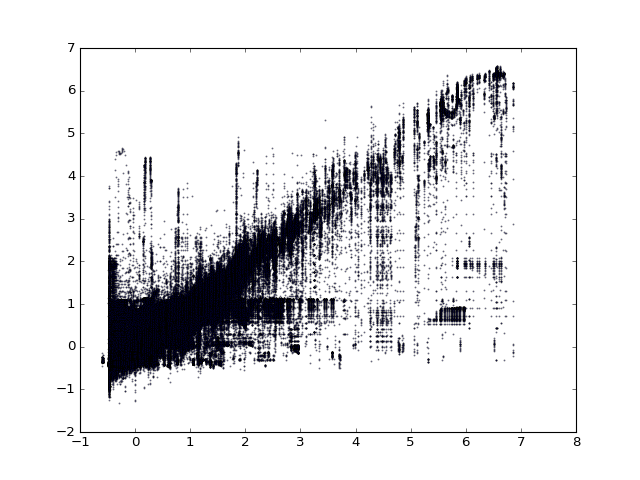

In [235]:
plt.scatter(y_.reshape(-1), yhat_.reshape(-1), s=0.5, alpha=0.5)

# 20-in, 1-out: I'm born superior to 20-in, 20-out, I can't fail!

Get data.

In [240]:
jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown','kijana','root']).dropna()

jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')

jobs.loc[:, 'Wait'] = jobs.loc[:, 'Start'] - jobs.loc[:, 'Submit']

jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
jobs = jobs.dropna()

Prepare data for ML.

In [241]:
jobs.loc[:, 'User'] = sklearn.preprocessing.LabelEncoder().fit_transform(jobs.loc[:, 'User'].copy())

In [243]:
jobs.loc[:, ['Wait', 'Timelimit']] = jobs.loc[:, ['Wait', 'Timelimit']].copy().values / pd.Timedelta('10h') # convert to number
jobs.loc[:, ['Wait', 'Timelimit', 'NNodes']] = sklearn.preprocessing.scale(jobs.loc[:, ['Wait', 'Timelimit', 'NNodes']].copy().values)

In [245]:
TIMESTEPS = 50
U_, X_, y_ = [[] for _ in range(3)]

for i in tqdm_notebook(range(TIMESTEPS, len(jobs))):
    
    tj = thisjob = jobs.iloc[i].copy()
    rj = related = jobs.iloc[i-TIMESTEPS:i+1].copy()
    
    U_.append(rj.loc[:, 'User'].copy().values) # [TIMESTEPS]
    
    rj.loc[:, 'Submit'] = (rj.loc[:, 'Submit'] - rj.iloc[0, 3]) / pd.Timedelta('10h')
    X_.append(rj.loc[:, ['NNodes', 'Timelimit', 'Submit']].copy().values) # [TIMESTEPS, 3]
    
    y_.append([rj.iloc[-1, 6]]) # [1]

HBox(children=(IntProgress(value=0, max=13084), HTML(value=u'')))

In [249]:
U_ = np.int32(U_)
X_ = np.float32(X_)
y_ = np.float32(y_)

Select model and train.

<IPython.core.display.Javascript object>


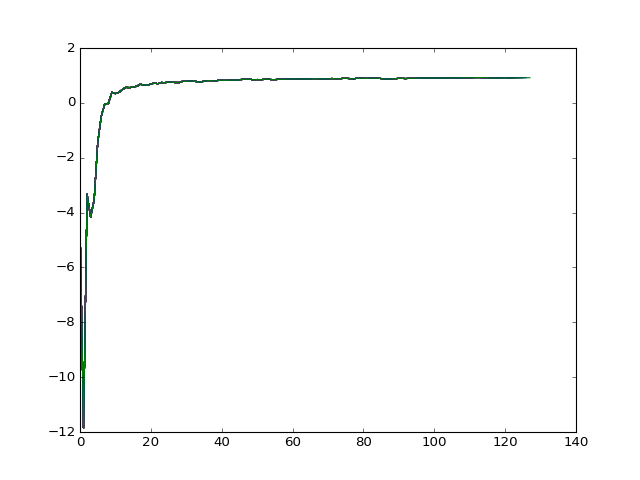

HBox(children=(IntProgress(value=0, max=1277), HTML(value=u'')))

Exception in thread Thread-12:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/local/lib/python2.7/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [252]:
# graph
U_VOCABULARY_SIZE = np.amax(U_)
N_EPOCHS = 100
BATCH_SIZE = 1024
N_SAMPLES = len(U_)

r2s = []
fig, ax = plt.subplots(1,1)
ax.set_ybound([-1,1])
tf.reset_default_graph()

U_id = tf.placeholder(name="U_id", dtype=tf.int32, shape=(None, None))
U_embeddings = tf.get_variable(name="U_embeddings", shape=[U_VOCABULARY_SIZE, 3])
U = tf.nn.embedding_lookup(U_embeddings, U_id, name="U")

X = tf.placeholder(name="X", dtype=tf.float32, shape=(None, None, 3))
XU = tf.concat([X,U], axis=-1, name="XU")
XU.set_shape([None, None, 6])

y = tf.placeholder(name="y", dtype=tf.float32, shape=(None, 1))

h1s, h1 = tf.nn.dynamic_rnn(tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(45), tf.contrib.rnn.GRUCell(35)]), XU, dtype=tf.float32)

h2 = tf.layers.dense(h1[1], units=25, activation=tf.tanh, name="h2")
yhat = tf.layers.dense(h2, units=1, activation=None, name="yhat")

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

# sess
sess = tf.Session()
sess.run(tf.global_variables_initializer())
t = tqdm_notebook(range(N_EPOCHS * N_SAMPLES / BATCH_SIZE))
for epoch in t:
    index = np.random.choice(range(N_SAMPLES), BATCH_SIZE, replace=False)
    sess.run(training_op, feed_dict={
        U_id: U_[index],
        X: X_[index],
        y: y_[index]
    })
    if epoch % 10 == 0:
        yhat_ = sess.run(yhat, feed_dict={
            U_id: U_,
            X: X_,
            y: y_
        })
        r2 = sklearn.metrics.r2_score(yhat_.reshape(-1), y_.reshape(-1))
        r2s.append(r2)
        t.set_description(str(r2))
        ax.plot(r2s)
        fig.canvas.draw()
        fig.canvas.show()
       

In [391]:
plt.scatter(y_.reshape(-1), yhat_.reshape(-1), s=0.5, alpha=0.5)

# Why?

Get data.

In [333]:
jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown','kijana','root']).dropna()

jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')

jobs.loc[:, 'Wait'] = jobs.loc[:, 'Start'] - jobs.loc[:, 'Submit']

jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
jobs = jobs.dropna()

Prepare data for ML.

In [334]:
jobs.loc[:, 'User'] = sklearn.preprocessing.LabelEncoder().fit_transform(jobs.loc[:, 'User'].copy())

In [335]:
jobs.loc[:, ['Wait', 'Timelimit']] = jobs.loc[:, ['Wait', 'Timelimit']].copy().values / pd.Timedelta('10h') # convert to number
jobs.loc[:, ['Wait', 'Timelimit', 'NNodes']] = sklearn.preprocessing.scale(jobs.loc[:, ['Wait', 'Timelimit', 'NNodes']].copy().values)

In [336]:
TIMESTEPS = 50
###0 U_, X_, y_ = [[] for _ in range(3)]
L_, U_, X_, y_ = [[] for _ in range(4)] ###2 

for i in tqdm_notebook(range(TIMESTEPS, len(jobs))):
    
    tj = thisjob = jobs.iloc[i].copy()
    ###0 rj = related = jobs.iloc[i-TIMESTEPS:i+1].copy()
    rj = related = jobs.loc[np.logical_and(jobs.Submit < tj.Submit, jobs.End > tj.End)].copy() ###2
    
    ###0
    if len(rj) == 0: ###2
        continue ###2
    L_.append(len(rj)) ###2
    
    U_.append(rj.loc[:, 'User'].copy().values) # [TIMESTEPS]
    
    rj.loc[:, 'Submit'] = (rj.loc[:, 'Submit'] - rj.iloc[0, 3]) / pd.Timedelta('10h')
    X_.append(rj.loc[:, ['NNodes', 'Timelimit', 'Submit']].copy().values) # [TIMESTEPS, 3]
    
    y_.append([rj.iloc[-1, 6]]) # [1]

HBox(children=(IntProgress(value=0, max=13084), HTML(value=u'')))

In [337]:
###0 U_ = np.int32(U_)
U_ = np.int32(keras.preprocessing.sequence.pad_sequences(U_)) ###1 ###MISTAKE:, dtype='float' ###POSSIBLE_MISTAKE: pre0 or post0
###0 X_ = np.float32(X_)
X_ = np.float32(keras.preprocessing.sequence.pad_sequences(X_)) ###1 ###MISTAKE: , dtype='float'
y_ = np.float32(y_)
###0
L_ = np.int32(L_) ###2

Select model and train.

<IPython.core.display.Javascript object>


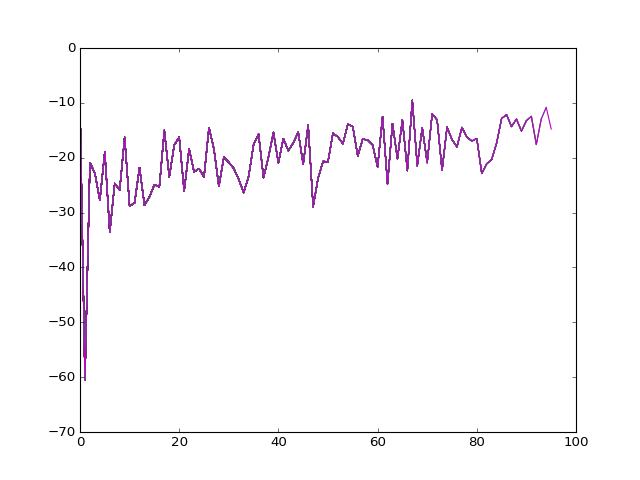

HBox(children=(IntProgress(value=0, max=958), HTML(value=u'')))

In [341]:
# graph
U_VOCABULARY_SIZE = np.amax(U_)
N_EPOCHS = 100
BATCH_SIZE = 1024
N_SAMPLES = len(U_)

r2s = []
fig, ax = plt.subplots(1,1)
###0 ax.set_ylim([-1,1])
tf.reset_default_graph()

###0
L = tf.placeholder(name="L", dtype=tf.int32, shape=(None)) ###2

U_id = tf.placeholder(name="U_id", dtype=tf.int32, shape=(None, None))
U_embeddings = tf.get_variable(name="U_embeddings", shape=[U_VOCABULARY_SIZE, 3])
U = tf.nn.embedding_lookup(U_embeddings, U_id, name="U")

X = tf.placeholder(name="X", dtype=tf.float32, shape=(None, None, 3))
XU = tf.concat([X,U], axis=-1, name="XU")
XU.set_shape([None, None, 6])

y = tf.placeholder(name="y", dtype=tf.float32, shape=(None, 1))

###0 h1s, h1 = tf.nn.dynamic_rnn(tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(45), tf.contrib.rnn.GRUCell(35)]), XU, dtype=tf.float32)
h1s, h1 = tf.nn.dynamic_rnn(tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(45), tf.contrib.rnn.GRUCell(35)]), XU, dtype=tf.float32, sequence_length=L) ###2

h2 = tf.layers.dense(h1[1], units=25, activation=tf.tanh, name="h2")
yhat = tf.layers.dense(h2, units=1, activation=None, name="yhat")

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

# sess
sess = tf.Session()
sess.run(tf.global_variables_initializer())
t = tqdm_notebook(range(N_EPOCHS * N_SAMPLES / BATCH_SIZE))
for epoch in t:
    index = np.random.choice(range(N_SAMPLES), BATCH_SIZE, replace=False)
    sess.run(training_op, feed_dict={
        U_id: U_[index],
        X: X_[index],
        y: y_[index],
        ###0
        L: L_[index]###2
    })
    if epoch % 10 == 0:
        yhat_ = sess.run(yhat, feed_dict={
            U_id: U_,
            X: X_,
            y: y_,
            ###0
            L: L_###2
        })
        r2 = sklearn.metrics.r2_score(yhat_.reshape(-1), y_.reshape(-1))
        r2s.append(r2)
        t.set_description(str(r2))
        ax.plot(r2s)
        fig.canvas.draw()
        fig.canvas.show()
       

In [ ]:
plt.scatter(y_.reshape(-1), yhat_.reshape(-1), s=0.5, alpha=0.5)

# 既然发现了错误，就重写一遍吧！ -  修复无目标行的Bug

Get data.

In [384]:
jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown','kijana','root']).dropna()

jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')

jobs.loc[:, 'Wait'] = jobs.loc[:, 'Start'] - jobs.loc[:, 'Submit']

jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
jobs = jobs.dropna()

Prepare data for ML.

In [385]:
jobs.loc[:, 'User'] = sklearn.preprocessing.LabelEncoder().fit_transform(jobs.loc[:, 'User'].copy())

In [386]:
jobs.loc[:, ['Wait', 'Timelimit']] = jobs.loc[:, ['Wait', 'Timelimit']].copy().values / pd.Timedelta('10h') # convert to number
jobs.loc[:, ['Wait', 'Timelimit', 'NNodes']] = sklearn.preprocessing.scale(jobs.loc[:, ['Wait', 'Timelimit', 'NNodes']].copy().values)

In [387]:
TIMESTEPS = 50

L_, U_, X_, y_ = [[] for _ in range(4)] ###2 

for i in tqdm_notebook(range(TIMESTEPS, len(jobs))):
    
    tj = thisjob = jobs.iloc[i].copy()
    rj = related = jobs.loc[np.logical_and(jobs.Submit < tj.Submit, jobs.End > tj.End)].copy() ###2
    
    if len(rj) == 0:
        continue
    L_.append(len(rj))
    
    U_.append(rj.loc[:, 'User'].copy().values) # [TIMESTEPS]
    
    rj.loc[:, 'Submit'] = (rj.loc[:, 'Submit'] - rj.iloc[0, 3]) / pd.Timedelta('10h')
    X_.append(rj.loc[:, ['NNodes', 'Timelimit', 'Submit']].copy().values) # [TIMESTEPS, 3]
    
    y_.append([rj.iloc[-1, 6]]) # [1]

HBox(children=(IntProgress(value=0, max=13084), HTML(value=u'')))

In [389]:
U_ = np.int32(keras.preprocessing.sequence.pad_sequences(U_, dtype='int', padding='post')) ###1 
X_ = np.float32(keras.preprocessing.sequence.pad_sequences(X_, dtype='float', padding='post')) ###1
y_ = np.float32(y_)
L_ = np.int32(L_)

Select model and train.

<IPython.core.display.Javascript object>


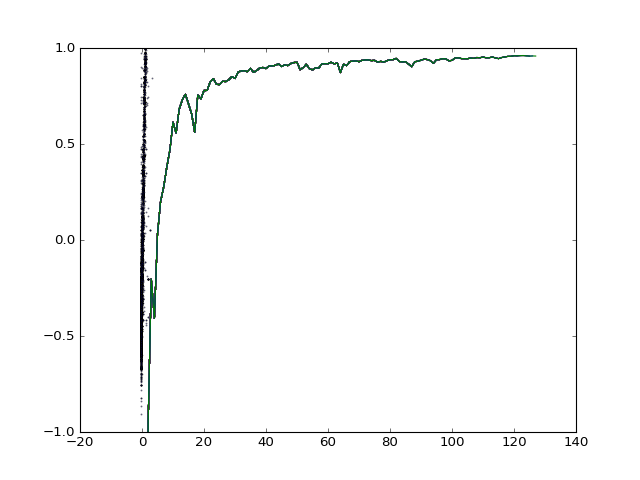

HBox(children=(IntProgress(value=0, max=1277), HTML(value=u'')))

In [390]:
# graph
U_VOCABULARY_SIZE = np.amax(U_)
N_EPOCHS = 100
BATCH_SIZE = 1024
N_SAMPLES = len(U_)

r2s = []
fig, ax = plt.subplots(1,1)
ax.set_ylim([-1,1])
tf.reset_default_graph()

L = tf.placeholder(name="L", dtype=tf.int32, shape=(None)) ###2

U_id = tf.placeholder(name="U_id", dtype=tf.int32, shape=(None, None))
U_embeddings = tf.get_variable(name="U_embeddings", shape=[U_VOCABULARY_SIZE, 3])
U = tf.nn.embedding_lookup(U_embeddings, U_id, name="U")

X = tf.placeholder(name="X", dtype=tf.float32, shape=(None, None, 3))
XU = tf.concat([X,U], axis=-1, name="XU")
XU.set_shape([None, None, 6])

y = tf.placeholder(name="y", dtype=tf.float32, shape=(None, 1))

h1s, h1 = tf.nn.dynamic_rnn(tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(45), tf.contrib.rnn.GRUCell(35)]), XU, dtype=tf.float32, sequence_length=L)

h2 = tf.layers.dense(h1[1], units=25, activation=tf.tanh, name="h2")
yhat = tf.layers.dense(h2, units=1, activation=None, name="yhat")

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

# sess
sess = tf.Session()
sess.run(tf.global_variables_initializer())
t = tqdm_notebook(range(N_EPOCHS * N_SAMPLES / BATCH_SIZE))
for epoch in t:
    index = np.random.choice(range(N_SAMPLES), BATCH_SIZE, replace=False)
    sess.run(training_op, feed_dict={
        U_id: U_[index],
        X: X_[index],
        y: y_[index],
        L: L_[index]
    })
    if epoch % 10 == 0:
        yhat_ = sess.run(yhat, feed_dict={
            U_id: U_,
            X: X_,
            y: y_,
            L: L_
        })
        r2 = sklearn.metrics.r2_score(yhat_.reshape(-1), y_.reshape(-1))
        r2s.append(r2)
        t.set_description(str(r2))
        ax.plot(r2s)
        fig.canvas.draw()
        fig.canvas.show()
       

<IPython.core.display.Javascript object>


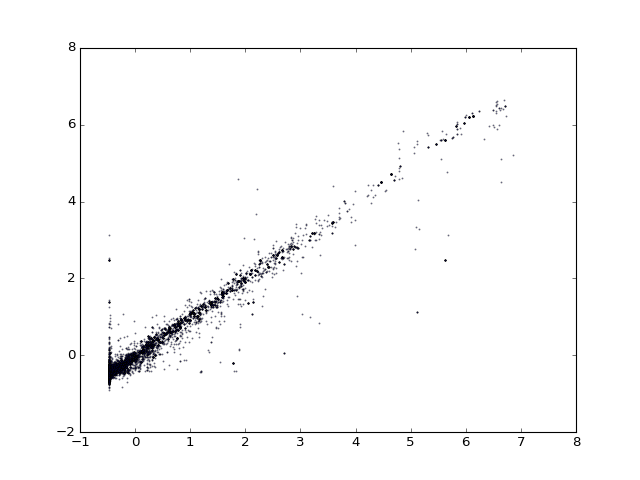

In [392]:
plt.close()
plt.scatter(y_.reshape(-1), yhat_.reshape(-1), s=0.5, alpha=0.5)
plt.show()

# 都95了，要不要再加一些已完成job的情况呢? - 97.6% Champion case

Get data.

In [416]:
jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown','kijana','root']).dropna()

jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')

jobs.loc[:, 'Wait'] = jobs.loc[:, 'Start'] - jobs.loc[:, 'Submit']

jobs.loc[:, 'Run'] = jobs.loc[:, 'End'] - jobs.loc[:, 'Start']

jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
jobs = jobs.dropna()

Prepare data for ML.

In [417]:
jobs.loc[:, 'User'] = sklearn.preprocessing.LabelEncoder().fit_transform(jobs.loc[:, 'User'].copy())

In [418]:
jobs.loc[:, ['Timelimit', 'Wait', 'Run']] = jobs.loc[:, ['Timelimit', 'Wait', 'Run']].copy().values / pd.Timedelta('10h') # convert to number
jobs.loc[:, ['NNodes', 'Timelimit', 'Run', 'Wait']] = sklearn.preprocessing.scale(jobs.loc[:, ['NNodes', 'Timelimit', 'Run', 'Wait']].copy().values)

In [ ]:
TIMESTEPS = 200
# U_, X_, y_ = [[] for _ in range(3)] 

def func(i, jobs):
    tj = thisjob = jobs.iloc[i].copy()
    rj = jobs.iloc[i-TIMESTEPS:i+1].copy()
    
    # U_.append(rj.loc[:, 'User'].copy().values) # [TIMESTEPS]
    
    rj.loc[:, 'Submit'] = (rj.loc[:, 'Submit'] - rj.iloc[0, 3]) / pd.Timedelta('10h')
    rj.loc[:, 'Is_complete'] = rj.loc[:, 'End'].copy() < tj.Submit
    rj.loc[:, 'Is_running'] = np.logical_and(rj.loc[:, 'End'].copy() > tj.Submit, rj.loc[:, 'Start'].copy() < tj.Submit)
    rj.loc[:, 'Is_queueing'] = rj.loc[:, 'Start'].copy() > tj.Submit
    rj.loc[:, 'Run2'] = rj.loc[:, 'Run'].copy().values * rj.loc[:, 'Is_complete'].copy().values
    rj.loc[:, 'Wait2'] = rj.loc[:, 'Wait'].copy().values * (rj.loc[:, 'Is_complete'].copy().values + rj.loc[:, 'Is_running'].copy().values)
    # X_.append(rj.loc[:, ['NNodes', 'Timelimit', 'Submit', 'Run2', 'Wait2', 'Is_complete', 'Is_running', 'Is_queueing']].copy().values) # [TIMESTEPS, 3]
    
    # y_.append([tj.Wait]) # [1]
    
    return [rj.loc[:, 'User'].copy().values, 
            rj.loc[:, ['NNodes', 'Timelimit', 'Submit', 'Run2', 'Wait2', 'Is_complete', 'Is_running', 'Is_queueing']].copy().values,
            [tj.Wait]]

# for i in tqdm_notebook(range(TIMESTEPS, len(jobs))):
    
L = joblib.Parallel(n_jobs=20)(joblib.delayed(func)(i, jobs) for i in tqdm_notebook(range(TIMESTEPS, len(jobs))))
U_, X_, y_ = zip(*L)

In [420]:
U_ = np.int32(keras.preprocessing.sequence.pad_sequences(U_, dtype='int', padding='post')) ###1 
X_ = np.float32(keras.preprocessing.sequence.pad_sequences(X_, dtype='float', padding='post')) ###1
y_ = np.float32(y_)
L_ = np.int32(L_)

Select model and train.

<IPython.core.display.Javascript object>


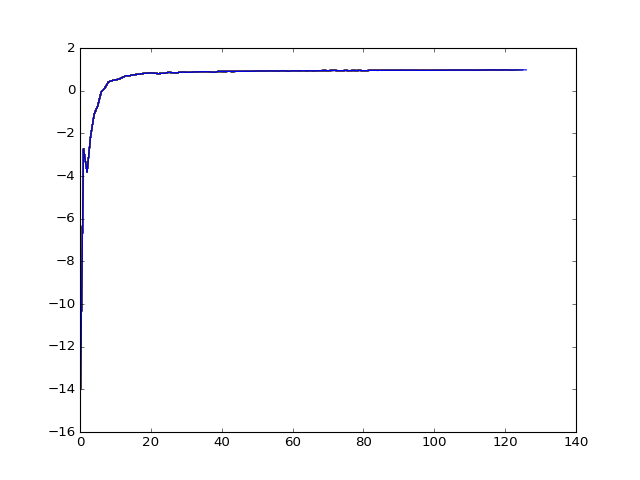

HBox(children=(IntProgress(value=0, max=1263), HTML(value=u'')))

In [421]:
# graph
U_VOCABULARY_SIZE = np.amax(U_)
N_EPOCHS = 100
BATCH_SIZE = 1024
N_SAMPLES = len(U_)

r2s = []
fig, ax = plt.subplots(1,1)
# ax.set_ylim([-1,1])
tf.reset_default_graph()

U_id = tf.placeholder(name="U_id", dtype=tf.int32, shape=(None, None))
U_embeddings = tf.get_variable(name="U_embeddings", shape=[U_VOCABULARY_SIZE, 3])
U = tf.nn.embedding_lookup(U_embeddings, U_id, name="U")

X = tf.placeholder(name="X", dtype=tf.float32, shape=(None, None, 8))
XU = tf.concat([X,U], axis=-1, name="XU")
XU.set_shape([None, None, 11])

y = tf.placeholder(name="y", dtype=tf.float32, shape=(None, 1))

h1s, h1 = tf.nn.dynamic_rnn(tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(45), tf.contrib.rnn.GRUCell(35)]), XU, dtype=tf.float32)

h2 = tf.layers.dense(h1[1], units=25, activation=tf.tanh, name="h2")
yhat = tf.layers.dense(h2, units=1, activation=None, name="yhat")

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

# sess
sess = tf.Session()
sess.run(tf.global_variables_initializer())
t = tqdm_notebook(range(N_EPOCHS * N_SAMPLES / BATCH_SIZE))
for epoch in t:
    index = np.random.choice(range(N_SAMPLES), BATCH_SIZE, replace=False)
    sess.run(training_op, feed_dict={
        U_id: U_[index],
        X: X_[index],
        y: y_[index]
    })
    if epoch % 10 == 0:
        yhat_ = sess.run(yhat, feed_dict={
            U_id: U_,
            X: X_,
            y: y_
        })
        r2 = sklearn.metrics.r2_score(yhat_.reshape(-1), y_.reshape(-1))
        r2s.append(r2)
        t.set_description(str(r2))
        ax.plot(r2s)
        fig.canvas.draw()
        fig.canvas.show()
       

<IPython.core.display.Javascript object>


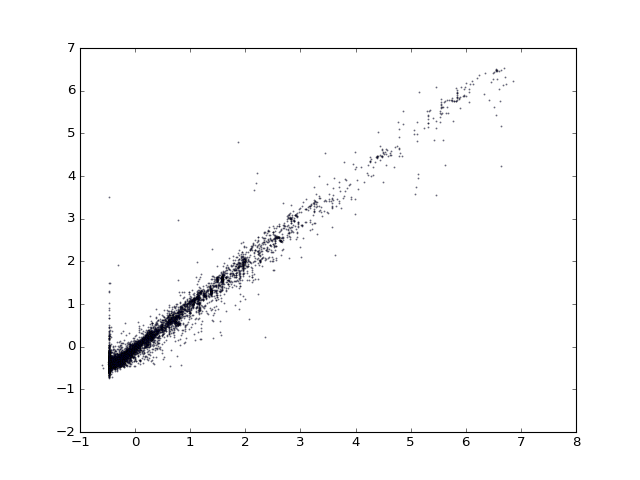

In [422]:
plt.close()
plt.scatter(y_.reshape(-1), yhat_.reshape(-1), s=0.5, alpha=0.5)
plt.show()

# Write functions, cross-validate

Get data.

In [21]:
def get_data_train():

    jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown','kijana','root']).dropna()

    jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
    jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
    jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

    jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

    jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
    jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')

    jobs.loc[:, 'Wait'] = jobs.loc[:, 'Start'] - jobs.loc[:, 'Submit']

    jobs.loc[:, 'Run'] = jobs.loc[:, 'End'] - jobs.loc[:, 'Start']

    jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
    jobs = jobs.dropna()
    
    return jobs

Prepare data for ML.

In [22]:
def prepare_for_ml_generate_rnn_inputs_parallel(i, jobs):
    TIMESTEPS = 200
    tj = thisjob = jobs.iloc[i].copy()
    rj = jobs.iloc[i-TIMESTEPS:i+1].copy()

    # U_.append(rj.loc[:, 'User'].copy().values) # [TIMESTEPS]

    rj.loc[:, 'Submit'] = (rj.loc[:, 'Submit'] - rj.iloc[0, 3]) / pd.Timedelta('10h')
    rj.loc[:, 'Is_complete'] = rj.loc[:, 'End'].copy() < tj.Submit
    rj.loc[:, 'Is_running'] = np.logical_and(rj.loc[:, 'End'].copy() > tj.Submit, rj.loc[:, 'Start'].copy() < tj.Submit)
    rj.loc[:, 'Is_queueing'] = rj.loc[:, 'Start'].copy() > tj.Submit
    rj.loc[:, 'Run2'] = rj.loc[:, 'Run'].copy().values * rj.loc[:, 'Is_complete'].copy().values
    rj.loc[:, 'Wait2'] = rj.loc[:, 'Wait'].copy().values * (rj.loc[:, 'Is_complete'].copy().values + rj.loc[:, 'Is_running'].copy().values)
    # X_.append(rj.loc[:, ['NNodes', 'Timelimit', 'Submit', 'Run2', 'Wait2', 'Is_complete', 'Is_running', 'Is_queueing']].copy().values) # [TIMESTEPS, 3]

    # y_.append([tj.Wait]) # [1]

    return [rj.loc[:, 'User'].copy().values, 
            rj.loc[:, ['NNodes', 'Timelimit', 'Submit', 'Run2', 'Wait2', 'Is_complete', 'Is_running', 'Is_queueing']].copy().values,
            [tj.Wait]] # instead, we return such a shitty cramped list, for parallelization

def prepare_for_ml_train(jobs):
    jobs = jobs.copy()
    
    # Label and scale
    User_lbe = sklearn.preprocessing.LabelEncoder()
    jobs.loc[:, 'User'] = User_lbe.fit_transform(jobs.loc[:, 'User'].copy())
    
    NNodes_Timelimit_Run_Wait_scaler = sklearn.preprocessing.StandardScaler()
    jobs.loc[:, ['Timelimit', 'Wait', 'Run']] = jobs.loc[:, ['Timelimit', 'Wait', 'Run']].copy().values / pd.Timedelta('10h') # convert to number
    jobs.loc[:, ['NNodes', 'Timelimit', 'Run', 'Wait']] = NNodes_Timelimit_Run_Wait_scaler.fit_transform(jobs.loc[:, ['NNodes', 'Timelimit', 'Run', 'Wait']].copy().values)
    
    # Produce RNN-style inputs
    TIMESTEPS = 200
    L = joblib.Parallel(n_jobs=20)(joblib.delayed(prepare_for_ml_generate_rnn_inputs_parallel)(i, jobs) for i in tqdm_notebook(range(TIMESTEPS, len(jobs))))
    U_, X_, y_ = zip(*L)
    
    U_ = np.int32(keras.preprocessing.sequence.pad_sequences(U_, dtype='int', padding='post')) ###1 
    X_ = np.float32(keras.preprocessing.sequence.pad_sequences(X_, dtype='float', padding='post')) ###1
    y_ = np.float32(y_)
    
    # Deployment
    with open('pickle', 'wb') as f:
        dict = {
            'User_lbe': User_lbe,
            'NNodes_Timelimit_Run_Wait_scaler': NNodes_Timelimit_Run_Wait_scaler
        }
        pickle.dump(dict, f)
    
    return U_, X_, y_

# Warning: duplication with prepare_for_ml_train
def prepare_for_ml_predict(jobs):
    jobs = jobs.copy()
    
    # Deployment
    with open('pickle', 'rb') as f:
        dict = pickle.load(f)
        User_lbe = dict['User_lbe']
        NNodes_Timelimit_Run_Wait_scaler = dict['NNodes_Timelimit_Run_Wait_scaler']
    
    # Label and scale
    jobs.loc[:, 'User'] = User_lbe.transform(jobs.loc[:, 'User'].copy())
    
    jobs.loc[:, ['Timelimit', 'Wait', 'Run']] = jobs.loc[:, ['Timelimit', 'Wait', 'Run']].copy().values / pd.Timedelta('10h') # convert to number
    jobs.loc[:, ['NNodes', 'Timelimit', 'Run', 'Wait']] = NNodes_Timelimit_Run_Wait_scaler.transform(jobs.loc[:, ['NNodes', 'Timelimit', 'Run', 'Wait']].copy().values)
    
    # Produce RNN-style inputs
    L = joblib.Parallel(n_jobs=20)(joblib.delayed(prepare_for_ml_generate_rnn_inputs_parallel)(i, jobs) for i in tqdm_notebook(range(TIMESTEPS, len(jobs))))
    U_, X_, y_ = zip(*L)
    
    U_ = np.int32(keras.preprocessing.sequence.pad_sequences(U_, dtype='int', padding='post')) ###1 
    X_ = np.float32(keras.preprocessing.sequence.pad_sequences(X_, dtype='float', padding='post')) ###1
    y_ = np.float32(y_)
    
    return U_, X_, y_

Select model and train.

In [42]:
def train_predict_generate_tensorflow_graph(U_VOCABULARY_SIZE):
    
    U_id = tf.placeholder(name="U_id", dtype=tf.int32, shape=(None, None))
    U_embeddings = tf.get_variable(name="U_embeddings", shape=[U_VOCABULARY_SIZE, 3])
    U = tf.nn.embedding_lookup(U_embeddings, U_id, name="U")

    X = tf.placeholder(name="X", dtype=tf.float32, shape=(None, None, 8))
    XU = tf.concat([X,U], axis=-1, name="XU")
    XU.set_shape([None, None, 11])

    y = tf.placeholder(name="y", dtype=tf.float32, shape=(None, 1))

    h1s, h1 = tf.nn.dynamic_rnn(tf.contrib.rnn.GRUCell(15), XU, dtype=tf.float32, scope="h1")
    yhat = tf.layers.dense(h1, units=1, activation=None, name="yhat")

    loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False, name="loss")
    training_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss, name="training_op")
    
    return U_id, X, y, yhat, training_op

def train(U_, X_, y_):
    
    N_EPOCHS = 100
    BATCH_SIZE = 1024
    N_SAMPLES = len(U_)

    r2s = []
    fig, ax = plt.subplots(1,1)
    ax.set_ylim([-1,1])
    
    # graph
    tf.reset_default_graph()
    U_id, X, y, yhat, training_op = train_predict_generate_tensorflow_graph(U_VOCABULARY_SIZE = np.amax(U_))

    # sess
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    t = tqdm_notebook(range(N_EPOCHS * N_SAMPLES / BATCH_SIZE))
    for epoch in t:
        index = np.random.choice(range(N_SAMPLES), BATCH_SIZE, replace=False)
        sess.run(training_op, feed_dict={
            U_id: U_[index],
            X: X_[index],
            y: y_[index]
        })
        if epoch % 10 == 0:
            yhat_ = sess.run(yhat, feed_dict={
                U_id: U_,
                X: X_,
                y: y_
            })
            r2 = sklearn.metrics.r2_score(yhat_.reshape(-1), y_.reshape(-1))
            r2s.append(r2)
            t.set_description(str(r2))
            ax.plot(r2s)
            fig.canvas.draw()
            fig.canvas.show()
            
    # Deployment
    tf.train.Saver().save(sess, './ckpt')
    sess.close()
            
    return yhat_

# Warning: duplication with train
def train_test(U_train, X_train, y_train, U_test, X_test, y_test):
        
    N_EPOCHS = 100
    BATCH_SIZE = 1024
    N_SAMPLES = len(U_train)

    r2s_train = []
    r2s_test = []
    fig, ax = plt.subplots(1,1)
    ax.set_ylim([-1,1])
    
    # graph
    tf.reset_default_graph()
    U_id, X, y, yhat, training_op = train_predict_generate_tensorflow_graph(U_VOCABULARY_SIZE = np.amax(U_train))

    # sess
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    t = tqdm_notebook(range(N_EPOCHS * N_SAMPLES / BATCH_SIZE))
    for epoch in t:
        index = np.random.choice(range(N_SAMPLES), BATCH_SIZE, replace=False)
        sess.run(training_op, feed_dict={
            U_id: U_train[index],
            X: X_train[index],
            y: y_train[index]
        })
        if epoch % 10 == 0:
            yhat_train = sess.run(yhat, feed_dict={
                U_id: U_train,
                X: X_train,
                y: y_train
            })
            r2_train = sklearn.metrics.r2_score(yhat_train.reshape(-1), y_train.reshape(-1))
            r2s_train.append(r2_train)
            ax.clear()
            ax.plot(r2s_train, label='r2_train')
            yhat_test = sess.run(yhat, feed_dict={
                U_id: U_test,
                X: X_test,
                y: y_test
            })
            r2_test = sklearn.metrics.r2_score(yhat_test.reshape(-1), y_test.reshape(-1))
            r2s_test.append(r2_test)
            t.set_description('{0:.2f}, {1:.2f}'.format(r2_train, r2_test))
            ax.plot(r2s_test, label='r2_test')
            ax.legend()
            fig.canvas.draw()
            fig.canvas.show()
            
    # Deployment
    tf.train.Saver().save(sess, './ckpt')
    sess.close()
            
    return yhat_train, yhat_test

def predict(U_, X_, y_):
    
    # graph
    tf.reset_default_graph()
    U_id, X, y, yhat, training_op = train_predict_generate_tensorflow_graph(U_VOCABULARY_SIZE = np.amax(U_))

    # sess
    sess = tf.Session()
    tf.train.Saver().restore(sess, './ckpt')
    yhat_ = sess.run(yhat, feed_dict={
        U_id: U_,
        X: X_,
        y: y_
    })
    
    return yhat_

Cross-validate.

HBox(children=(IntProgress(value=0, max=12934), HTML(value=u'')))

<IPython.core.display.Javascript object>


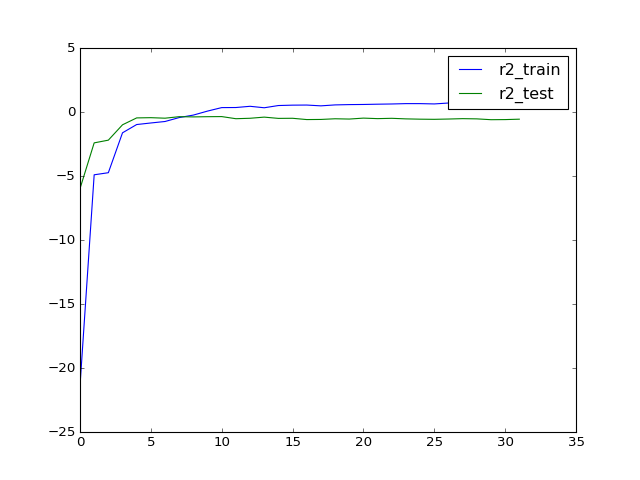

HBox(children=(IntProgress(value=0, max=757), HTML(value=u'')))

KeyboardInterrupt: 

In [43]:
jobs = get_data_train()

U_, X_, y_ = prepare_for_ml_train(jobs)

Ntrain = int(len(U_) * 0.6)
Ntest = int(len(U_) * 0.8)
U_train, X_train, y_train = U_[:Ntrain], X_[:Ntrain], y_[:Ntrain]
U_test, X_test, y_test = U_[Ntrain:Ntest], X_[Ntrain:Ntest], y_[Ntrain:Ntest]
yhat_train, yhat_test = train_test(U_train, X_train, y_train, U_test, X_test, y_test)

# Overfit!

Get data.

In [28]:
jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown','kijana','root']).dropna()

jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')

jobs.loc[:, 'Wait'] = jobs.loc[:, 'Start'] - jobs.loc[:, 'Submit']

jobs.loc[:, 'Run'] = jobs.loc[:, 'End'] - jobs.loc[:, 'Start']

jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
jobs = jobs.dropna()

Prepare data for ML.

In [29]:
jobs.loc[:, 'User'] = sklearn.preprocessing.LabelEncoder().fit_transform(jobs.loc[:, 'User'].copy())

In [30]:
jobs.loc[:, ['Timelimit', 'Wait', 'Run']] = jobs.loc[:, ['Timelimit', 'Wait', 'Run']].copy().values / pd.Timedelta('10h') # convert to number
jobs.loc[:, ['NNodes', 'Timelimit', 'Run', 'Wait']] = sklearn.preprocessing.scale(jobs.loc[:, ['NNodes', 'Timelimit', 'Run', 'Wait']].copy().values)

In [31]:
TIMESTEPS = 100

def func(i, jobs):
    tj = thisjob = jobs.iloc[i].copy()
    rj = jobs.iloc[i-TIMESTEPS:i+1].copy()
    
    rj.loc[:, 'Is_complete'] = rj.loc[:, 'End'].copy() < tj.Submit
    rj.loc[:, 'Is_running'] = np.logical_and(rj.loc[:, 'End'].copy() > tj.Submit, rj.loc[:, 'Start'].copy() < tj.Submit)
    rj.loc[:, 'Is_queueing'] = rj.loc[:, 'Start'].copy() > tj.Submit
    rj.loc[:, 'Run'] = rj.loc[:, 'Run'].copy().values * rj.loc[:, 'Is_complete'].copy().values
    rj.loc[:, 'Wait'] = rj.loc[:, 'Wait'].copy().values * (rj.loc[:, 'Is_complete'].copy().values + rj.loc[:, 'Is_running'].copy().values)
    rj.loc[:, 'Queue'] = (rj.loc[:, 'Submit'] - rj.iloc[0, 3]) / pd.Timedelta('10h')
    
    rj.loc[:, 'Submit'] = pd.to_numeric(rj.loc[:, 'Submit'].copy())
    
    return [rj.loc[:, 'User'].copy().values, 
            rj.loc[:, ['NNodes', 'Timelimit', 'Submit', 'Run', 'Wait', 'Queue', 'Is_complete', 'Is_running', 'Is_queueing']].copy().values,
            [tj.Wait]]
    
L = joblib.Parallel(n_jobs=20)(joblib.delayed(func)(i, jobs) for i in tqdm_notebook(range(TIMESTEPS, len(jobs))))
U_, X_, y_ = zip(*L)

HBox(children=(IntProgress(value=0, max=13034), HTML(value=u'')))

In [32]:
U_ = np.int32(keras.preprocessing.sequence.pad_sequences(U_, dtype='int', padding='post')) ###1 
X_ = np.float32(keras.preprocessing.sequence.pad_sequences(X_, dtype='float', padding='post')) ###1
y_ = np.float32(y_)

In [33]:
Xscaler = sklearn.preprocessing.StandardScaler().fit(X_.reshape(-1, X_.shape[-1]))
X_ = np.array([Xscaler.transform(_) for _ in X_])
y_ = sklearn.preprocessing.scale(y_)

Take a sample.

In [38]:
# Ntrain = int(len(U_) * 0.78)
# Ntest = int(len(U_) * 0.8)
# U_train, X_train, y_train = U_[:Ntrain], X_[:Ntrain], y_[:Ntrain]
# U_test, X_test, y_test = U_[Ntrain:Ntest], X_[Ntrain:Ntest], y_[Ntrain:Ntest]

# U_train, U_test, X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(U_, X_, y_, train_size=0.6, test_size=0.2)

trainS = np.random.randint(low=0, high=12500)
trainE = testS = trainS + 500
testE = trainS + 510
U_train, X_train, y_train = U_[trainS:trainE], X_[trainS:trainE], y_[trainS:trainE]
U_test, X_test, y_test = U_[testS:testE], X_[testS:testE], y_[testS:testE]


Select model and train.

<IPython.core.display.Javascript object>


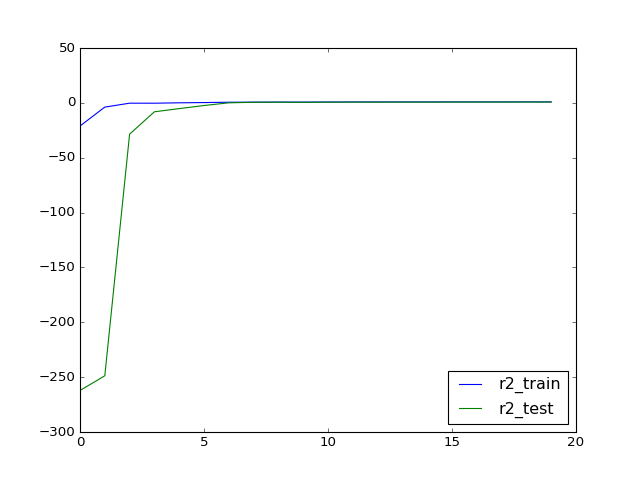

HBox(children=(IntProgress(value=0, max=195), HTML(value=u'')))

In [40]:
# graph
U_VOCABULARY_SIZE = np.amax(U_)
N_EPOCHS = 100
BATCH_SIZE = 256
N_SAMPLES = len(U_train)

r2s_train = []
r2s_test = []
fig, ax = plt.subplots(1,1)
tf.reset_default_graph()

U_id = tf.placeholder(name="U_id", dtype=tf.int32, shape=(None, None))
U_embeddings = tf.get_variable(name="U_embeddings", shape=[U_VOCABULARY_SIZE, 3])
U = tf.nn.embedding_lookup(U_embeddings, U_id, name="U")

X = tf.placeholder(name="X", dtype=tf.float32, shape=(None, None, 8))
XU = tf.concat([X,U], axis=-1, name="XU")
XU.set_shape([None, None, 11])

y = tf.placeholder(name="y", dtype=tf.float32, shape=(None, 1))

# hs, h = tf.nn.dynamic_rnn(tf.contrib.rnn.GRUCell(5), X, dtype=tf.float32)
# yhat = tf.layers.dense(h, units=1, activation=None, name="yhat")
hs, h = tf.nn.dynamic_rnn(tf.contrib.rnn.MultiRNNCell([tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(45), tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(35)]), XU, dtype=tf.float32)
h = tf.layers.dense(h[1], units=25, activation=tf.tanh, name="h2")
yhat = tf.layers.dense(h, units=1, activation=None, name="yhat")

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

# sess
sess = tf.Session()
sess.run(tf.global_variables_initializer())
t = tqdm_notebook(range(N_EPOCHS * N_SAMPLES / BATCH_SIZE))
for epoch in t:
    index = np.random.choice(range(N_SAMPLES), BATCH_SIZE, replace=False)
    sess.run(training_op, feed_dict={
        U_id: U_train[index],
        X: X_train[index],
        y: y_train[index]
    })
    if epoch % 10 == 0:
        yhat_train = sess.run(yhat, feed_dict={
            U_id: U_train,
            X: X_train,
            y: y_train
        })
        r2_train = sklearn.metrics.r2_score(yhat_train.reshape(-1), y_train.reshape(-1))
        r2s_train.append(r2_train)
        ax.clear()
        ax.plot(r2s_train, label='r2_train')
        yhat_test = sess.run(yhat, feed_dict={
            U_id: U_test,
            X: X_test,
            y: y_test
        })
        r2_test = sklearn.metrics.r2_score(yhat_test.reshape(-1), y_test.reshape(-1))
        r2s_test.append(r2_test)
        t.set_description('{0:.2f}, {1:.2f}'.format(r2_train, r2_test))
        ax.plot(r2s_test, label='r2_test')
        ax.legend(loc='bottom right')
        fig.canvas.draw()
        fig.canvas.show()
        fig.canvas.draw()
        fig.canvas.show()
       

<IPython.core.display.Javascript object>


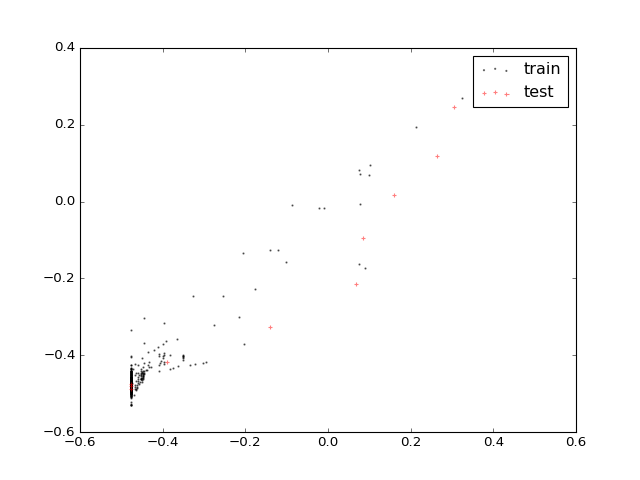

In [48]:
plt.close()
plt.scatter(y_train.reshape(-1), yhat_train.reshape(-1), s=1, alpha=0.5, color='black', label='train', marker='o')
plt.scatter(y_test.reshape(-1), yhat_test.reshape(-1), s=15, alpha=0.5, color='red', label='test', marker='+')
plt.legend()
plt.show()

In [ ]:
def r2_score(ytrue, ypred): # sklearn.metrics.r2_score in tensorflow. 1 output only. 

    ytrue_mean = tf.reduce_mean(ytrue, name="ytrue_mean")
    r2_score = tf.subtract(1., tf.truediv(tf.reduce_mean((ytrue - ypred) ** 2), tf.reduce_mean((ytrue - ytrue_mean) ** 2)), name="r2_score")
    return r2_score

model = keras.models.Sequential([
    keras.layers.CuDNNGRU(units=35, input_shape=(None,8)),
    keras.layers.Dense(units=1)
])
model.compile(loss='mse', optimizer='sgd', metrics=[r2_score])
model.fit(X_, y_, validation_split=0.2, batch_size=1024, shuffle=True, epochs=300)


# Okay, paradigm shift, got it. How short a period?

In [299]:
TIMESTEPS = 50
TRAIN_SIZE = 1000
TEST_SIZE = 2000

DELAY = 0
TOTAL_SIZE = TRAIN_SIZE + DELAY + TEST_SIZE

In [286]:
# Get data
jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown','kijana','root']).dropna()

jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')

jobs.loc[:, 'Wait'] = jobs.loc[:, 'Start'] - jobs.loc[:, 'Submit']

jobs.loc[:, 'Run'] = jobs.loc[:, 'End'] - jobs.loc[:, 'Start']

jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
jobs = jobs.dropna()

# Prepare data for ML
jobs.loc[:, 'User'] = sklearn.preprocessing.LabelEncoder().fit_transform(jobs.loc[:, 'User'].copy())

jobs.loc[:, ['Timelimit', 'Wait', 'Run']] = jobs.loc[:, ['Timelimit', 'Wait', 'Run']].copy().values / pd.Timedelta('10h') # convert to number

In [300]:
# Get sample
def extract_sample(i, jobs, TIMESTEPS = TIMESTEPS):
    tj = thisjob = jobs.iloc[i].copy()
    rj = jobs.iloc[i-TIMESTEPS:i+1].copy()
    
    rj.loc[:, 'Is_complete'] = rj.loc[:, 'End'].copy() < tj.Submit
    rj.loc[:, 'Is_running'] = np.logical_and(rj.loc[:, 'End'].copy() > tj.Submit, rj.loc[:, 'Start'].copy() < tj.Submit)
    rj.loc[:, 'Is_queueing'] = rj.loc[:, 'Start'].copy() > tj.Submit
    rj.loc[:, 'Run'] = rj.loc[:, 'Run'].copy().values * rj.loc[:, 'Is_complete'].copy().values
    rj.loc[:, 'Wait'] = rj.loc[:, 'Wait'].copy().values * (rj.loc[:, 'Is_complete'].copy().values + rj.loc[:, 'Is_running'].copy().values)
    rj.loc[:, 'Queue'] = (rj.loc[:, 'Submit'] - rj.iloc[0, 3]) / pd.Timedelta('10h')
    
    rj.loc[:, 'Submit'] = pd.to_numeric(rj.loc[:, 'Submit'].copy())
    
    return [rj.loc[:, 'User'].copy().values, 
            rj.loc[:, ['NNodes', 'Timelimit']].copy().values, # 'Wait', 'Submit', 'Run', 'Queue', 'Is_complete', 'Is_running', 'Is_queueing'
            [tj.Wait]]

S = 9354 # np.random.randint(0, 13000 - TOTAL_SIZE)
L = joblib.Parallel(n_jobs=20)(joblib.delayed(extract_sample)(i, jobs) for i in range(S, S + TOTAL_SIZE))
U_ = np.int32(zip(*L)[0])
X_ = np.float32(zip(*L)[1])
y_ = np.float32(zip(*L)[2])

# Prepare sample for ML
Xscaler = sklearn.preprocessing.StandardScaler().fit(X_.reshape(-1, X_[:TRAIN_SIZE].shape[-1]))
X_scaled = np.array([Xscaler.transform(_) for _ in X_])
yscaler = sklearn.preprocessing.StandardScaler().fit(y_[:TRAIN_SIZE])
y_scaled = sklearn.preprocessing.scale(y_)

U_train, X_train, y_train = U_[:TRAIN_SIZE], X_scaled[:TRAIN_SIZE], y_scaled[:TRAIN_SIZE]
U_test, X_test, y_test = U_[-TEST_SIZE:], X_scaled[-TEST_SIZE:], y_scaled[-TEST_SIZE:]
# U_train, U_test, X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(U_, X_scaled, y_scaled, train_size=0.95, test_size=0.05)

if np.random.rand() > np.std(y_test):
    raise ValueError

<IPython.core.display.Javascript object>


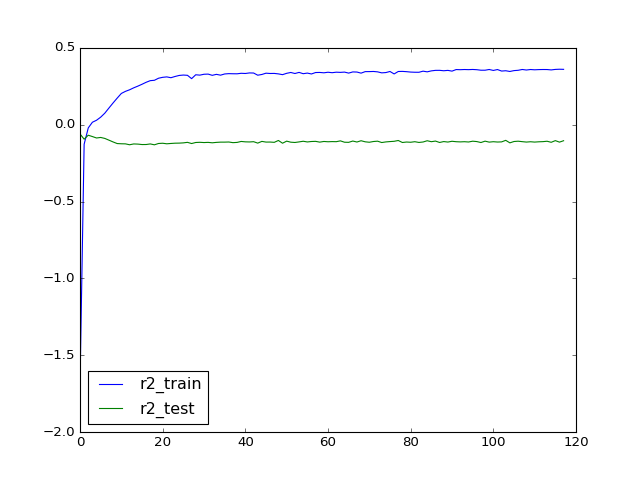

HBox(children=(IntProgress(value=0, max=1171), HTML(value=u'')))

In [301]:
# Select a model and train

# graph
U_VOCABULARY_SIZE = np.amax(U_) + 1
N_EPOCHS = 300
BATCH_SIZE = 256

r2s_train = []
r2s_test = []
fig, ax = plt.subplots(1,1)
tf.reset_default_graph()

U_id = tf.placeholder(name="U_id", dtype=tf.int32, shape=(None, None))
U_embeddings = tf.get_variable(name="U_embeddings", shape=[U_VOCABULARY_SIZE, 3])
U = tf.nn.embedding_lookup(U_embeddings, U_id, name="U")

X = tf.placeholder(name="X", dtype=tf.float32, shape=(None, None, 2))
XU = tf.concat([X,U], axis=-1, name="XU")
XU.set_shape([None, None, 5])

y = tf.placeholder(name="y", dtype=tf.float32, shape=(None, 1))

keep_prob = tf.placeholder(name="keep_prob", dtype=tf.float32, shape=())

# hs, h = tf.nn.dynamic_rnn(tf.contrib.rnn.GRUCell(5), X, dtype=tf.float32)
hs, h = tf.nn.dynamic_rnn(tf.contrib.rnn.MultiRNNCell([tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(5), tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(1)]), XU, dtype=tf.float32)
# h = tf.nn.dropout(h[1], keep_prob=keep_prob)
yhat = tf.layers.dense(h[1], units=1, activation=None, name="yhat")

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)
# training_op = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.91, use_nesterov=True).minimize(loss)

# sess
sess = tf.Session()
sess.run(tf.global_variables_initializer())
t = tqdm_notebook(range(N_EPOCHS * TRAIN_SIZE / BATCH_SIZE))
for epoch in t:
    index = np.random.choice(range(TRAIN_SIZE), BATCH_SIZE, replace=False)
    sess.run(training_op, feed_dict={
        U_id: U_train[index],
        X: X_train[index],
        y: y_train[index]
    })
    if epoch % 10 == 0:
        yhat_train = sess.run(yhat, feed_dict={
            U_id: U_train,
            X: X_train,
            y: y_train
        })
        r2_train = sklearn.metrics.r2_score(y_train.reshape(-1), yhat_train.reshape(-1))
        r2s_train.append(r2_train)
        ax.clear()
        ax.plot(r2s_train, label='r2_train')
        yhat_test = sess.run(yhat, feed_dict={
            U_id: U_test,
            X: X_test,
            y: y_test
        })
        r2_test = sklearn.metrics.r2_score(y_test.reshape(-1), yhat_test.reshape(-1))
        r2s_test.append(r2_test)
        t.set_description('{0:.2f}, {1:.2f}'.format(r2_train, r2_test))
        ax.plot(r2s_test, label='r2_test')
        ax.legend(loc='best')
        fig.canvas.draw()
        fig.canvas.show()
sess.close()

<IPython.core.display.Javascript object>


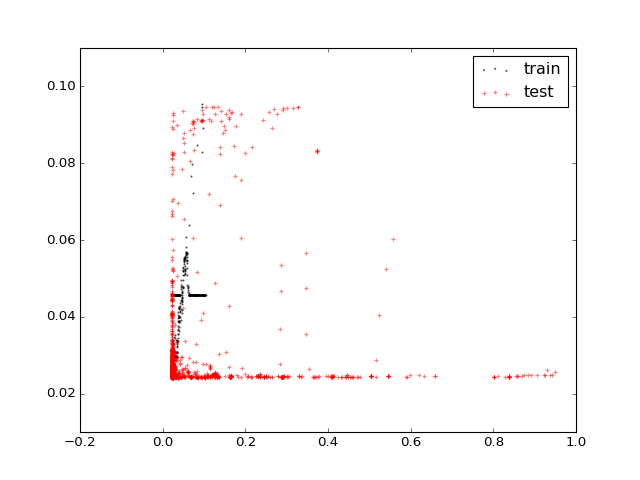

In [302]:
plt.close()
plt.scatter(yscaler.inverse_transform(y_train).reshape(-1), yscaler.inverse_transform(yhat_train).reshape(-1), s=1, alpha=0.5, color='black', label='train', marker='o')
plt.scatter(yscaler.inverse_transform(y_test).reshape(-1), yscaler.inverse_transform(yhat_test).reshape(-1), s=15, alpha=0.5, color='red', label='test', marker='+')
plt.legend()
plt.show()

# Don't try to write all-good, inefficient functions yourself.

In [ ]:
# dataviz
fig_train, ax_train = plt.subplots(1,1)
fig_test, ax_test = plt.subplots(1,1)
y_train_invs = []
yhat_train_invs = []
y_test_invs = []
yhat_test_invs = []

In [ ]:
# Select model and train

# graph
tf.reset_default_graph()
U_VOCABULARY_SIZE = np.amax(U_)
N_EPOCHS = 100
BATCH_SIZE = 256
N_SAMPLES = len(U_train)

U_id = tf.placeholder(name="U_id", dtype=tf.int32, shape=(None, None))
U_embeddings = tf.get_variable(name="U_embeddings", shape=[U_VOCABULARY_SIZE, 3])
U = tf.nn.embedding_lookup(U_embeddings, U_id, name="U")

X = tf.placeholder(name="X", dtype=tf.float32, shape=(None, None, 9))
XU = tf.concat([X,U], axis=-1, name="XU")
XU.set_shape([None, None, 12])

y = tf.placeholder(name="y", dtype=tf.float32, shape=(None, 1))

# hs, h = tf.nn.dynamic_rnn(tf.contrib.rnn.GRUCell(5), X, dtype=tf.float32)
# yhat = tf.layers.dense(h, units=1, activation=None, name="yhat")
hs, h = tf.nn.dynamic_rnn(tf.contrib.rnn.MultiRNNCell([tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(15), tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(5)]), XU, dtype=tf.float32)
h = tf.layers.dense(h[1], units=5, activation=tf.tanh, name="h2")
yhat = tf.layers.dense(h, units=1, activation=None, name="yhat")

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False, name="loss")
training_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

# sess
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in tqdm_notebook(range(N_EPOCHS * N_SAMPLES / BATCH_SIZE), desc='training', leave=False):
    index = np.random.choice(range(N_SAMPLES), BATCH_SIZE, replace=False)
    sess.run(training_op, feed_dict={
        U_id: U_train[index],
        X: X_train[index],
        y: y_train[index]
    })
yhat_train = sess.run(yhat, feed_dict={
    U_id: U_train,
    X: X_train,
    y: y_train
})
yhat_test = sess.run(yhat, feed_dict={
    U_id: U_test,
    X: X_test,
    y: y_test
})
ax_train.scatter(yscaler.inverse_transform(y_train).reshape(-1), yscaler.inverse_transform(yhat_train).reshape(-1), s=3, alpha=0.5, label='train / 10h')
fig_train.canvas.draw() ; fig_train.canvas.show()
y_train_invs += yscaler.inverse_transform(y_train).reshape(-1).tolist() ; yhat_train_invs += yscaler.inverse_transform(yhat_train).reshape(-1).tolist()
ax_test.scatter(yscaler.inverse_transform(y_test).reshape(-1), yscaler.inverse_transform(yhat_test).reshape(-1), s=3, alpha=0.5, label='test / 10h')
fig_test.canvas.draw() ; fig_test.canvas.show()
y_test_invs += yscaler.inverse_transform(y_test).reshape(-1).tolist() ; yhat_train_invs += yscaler.inverse_transform(yhat_test).reshape(-1).tolist()


sess.close()

HBox(children=(IntProgress(value=0, description=u'training', max=390), HTML(value=u'')))

In [91]:
# Select model and train

# graph
tf.reset_default_graph()
U_VOCABULARY_SIZE = np.amax(U_)
N_EPOCHS = 100
BATCH_SIZE = 256
N_SAMPLES = len(U_train)

U_id = tf.placeholder(name="U_id", dtype=tf.int32, shape=(None, None))
U_embeddings = tf.get_variable(name="U_embeddings", shape=[U_VOCABULARY_SIZE, 3])
U = tf.nn.embedding_lookup(U_embeddings, U_id, name="U")

X = tf.placeholder(name="X", dtype=tf.float32, shape=(None, None, 9))
XU = tf.concat([X,U], axis=-1, name="XU")
XU.set_shape([None, None, 12])

y = tf.placeholder(name="y", dtype=tf.float32, shape=(None, 1))

# hs, h = tf.nn.dynamic_rnn(tf.contrib.rnn.GRUCell(5), X, dtype=tf.float32)
# yhat = tf.layers.dense(h, units=1, activation=None, name="yhat")
hs, h = tf.nn.dynamic_rnn(tf.contrib.rnn.MultiRNNCell([tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(15), tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(5)]), XU, dtype=tf.float32)
h = tf.layers.dense(h[1], units=5, activation=tf.tanh, name="h2")
yhat = tf.layers.dense(h, units=1, activation=None, name="yhat")

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False, name="loss")
training_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

# sess
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in tqdm_notebook(range(N_EPOCHS * N_SAMPLES / BATCH_SIZE), desc='training', leave=False):
    index = np.random.choice(range(N_SAMPLES), BATCH_SIZE, replace=False)
    sess.run(training_op, feed_dict={
        U_id: U_train[index],
        X: X_train[index],
        y: y_train[index]
    })
yhat_train = sess.run(yhat, feed_dict={
    U_id: U_train,
    X: X_train,
    y: y_train
})
yhat_test = sess.run(yhat, feed_dict={
    U_id: U_test,
    X: X_test,
    y: y_test
})
ax_train.scatter(yscaler.inverse_transform(y_train).reshape(-1), yscaler.inverse_transform(yhat_train).reshape(-1), s=3, alpha=0.5, label='train / 10h')
fig_train.canvas.draw() ; fig_train.canvas.show()
y_train_invs += yscaler.inverse_transform(y_train).reshape(-1).tolist() ; yhat_train_invs += yscaler.inverse_transform(yhat_train).reshape(-1).tolist()
ax_test.scatter(yscaler.inverse_transform(y_test).reshape(-1), yscaler.inverse_transform(yhat_test).reshape(-1), s=3, alpha=0.5, label='test / 10h')
fig_test.canvas.draw() ; fig_test.canvas.show()
y_test_invs += yscaler.inverse_transform(y_test).reshape(-1).tolist() ; yhat_train_invs += yscaler.inverse_transform(yhat_test).reshape(-1).tolist()


sess.close()

HBox(children=(IntProgress(value=0, description=u'training', max=195), HTML(value=u'')))

In [ ]:
# dataviz
fig_train, ax_train = plt.subplots(1,1)
fig_test, ax_test = plt.subplots(1,1)
y_train_invs = []
yhat_train_invs = []
y_test_invs = []
yhat_test_invs = []

In [29]:
def is_iterable(L):
    return hasattr(L, '__iter__')

def to_iterable(L):
    if isinstance(L, (np.ndarray, np.generic)):
        return L.tolist()
    if isinstance(L, pd.DataFrame):
        return L.values.tolist()
    if is_iterable(L):
        return recursive_map(lambda x:x, L)
    raise ValueError
    
def flatten(L):
    return reduce(operator.add, map(lambda l: flatten(l) if is_iterable(l) else [l], L))

def recursive_map(func, L):
    return map(lambda l: recursive_map(func, l) if is_iterable(l) else func(l), L)

def get_index(item, L, index_unexpected=-1, random_unexpected=0.): # first occurence or -1
    return index_unexpected if np.random.rand() < random_unexpected or item not in L else np.argmax(np.array(L)==item)

def get_value(index, L, value_unexpected_index=None, index_unexpected=-1): # L[index] or None
    return value_unexpected_index if index == index_unexpected else L[index]

In [91]:
# Select model and train

# graph
tf.reset_default_graph()
U_VOCABULARY_SIZE = np.amax(U_)
N_EPOCHS = 100
BATCH_SIZE = 256
N_SAMPLES = len(U_train)

U_id = tf.placeholder(name="U_id", dtype=tf.int32, shape=(None, None))
U_embeddings = tf.get_variable(name="U_embeddings", shape=[U_VOCABULARY_SIZE, 3])
U = tf.nn.embedding_lookup(U_embeddings, U_id, name="U")

X = tf.placeholder(name="X", dtype=tf.float32, shape=(None, None, 9))
XU = tf.concat([X,U], axis=-1, name="XU")
XU.set_shape([None, None, 12])

y = tf.placeholder(name="y", dtype=tf.float32, shape=(None, 1))

# hs, h = tf.nn.dynamic_rnn(tf.contrib.rnn.GRUCell(5), X, dtype=tf.float32)
# yhat = tf.layers.dense(h, units=1, activation=None, name="yhat")
hs, h = tf.nn.dynamic_rnn(tf.contrib.rnn.MultiRNNCell([tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(15), tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(5)]), XU, dtype=tf.float32)
h = tf.layers.dense(h[1], units=5, activation=tf.tanh, name="h2")
yhat = tf.layers.dense(h, units=1, activation=None, name="yhat")

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False, name="loss")
training_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

# sess
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in tqdm_notebook(range(N_EPOCHS * N_SAMPLES / BATCH_SIZE), desc='training', leave=False):
    index = np.random.choice(range(N_SAMPLES), BATCH_SIZE, replace=False)
    sess.run(training_op, feed_dict={
        U_id: U_train[index],
        X: X_train[index],
        y: y_train[index]
    })
yhat_train = sess.run(yhat, feed_dict={
    U_id: U_train,
    X: X_train,
    y: y_train
})
yhat_test = sess.run(yhat, feed_dict={
    U_id: U_test,
    X: X_test,
    y: y_test
})
ax_train.scatter(yscaler.inverse_transform(y_train).reshape(-1), yscaler.inverse_transform(yhat_train).reshape(-1), s=3, alpha=0.5, label='train / 10h')
fig_train.canvas.draw() ; fig_train.canvas.show()
y_train_invs += yscaler.inverse_transform(y_train).reshape(-1).tolist() ; yhat_train_invs += yscaler.inverse_transform(yhat_train).reshape(-1).tolist()
ax_test.scatter(yscaler.inverse_transform(y_test).reshape(-1), yscaler.inverse_transform(yhat_test).reshape(-1), s=3, alpha=0.5, label='test / 10h')
fig_test.canvas.draw() ; fig_test.canvas.show()
y_test_invs += yscaler.inverse_transform(y_test).reshape(-1).tolist() ; yhat_train_invs += yscaler.inverse_transform(yhat_test).reshape(-1).tolist()


sess.close()

HBox(children=(IntProgress(value=0, description=u'training', max=195), HTML(value=u'')))

In [30]:
def r2_score(ytrue, ypred): # sklearn.metrics.r2_score in tensorflow. 1 output only. 

    ytrue_mean = tf.reduce_mean(ytrue, name="ytrue_mean")
    r2_score = tf.subtract(1., tf.truediv(tf.reduce_mean((ytrue - ypred) ** 2), tf.reduce_mean((ytrue - ytrue_mean) ** 2)), name="r2_score")
    return r2_score

class TqdmProgBar(keras.callbacks.Callback):
    def __init__(self, n_epochs, field, fig, ax, label): # logs[field] is updated in tqdm bar and plotted in fig, ax with label
        self.n_epochs = n_epochs
        self.field = field
        self.fig = fig
        self.ax = ax
        self.label = label
        self.logs = []
    def on_train_begin(self, logs):
        self.pbar = tqdm_notebook(total=self.n_epochs, leave=False)
    def on_train_end(self, logs):
        self.pbar.close()
        self.ax.plot(range(len(self.logs)), self.logs, label=self.label)
        self.ax.set_ylim(bottom=-0.1)
        self.fig.canvas.draw()
        self.ax.legend()
        plt.legend()
    def on_epoch_end(self, epoch, logs):
        self.pbar.set_description("%.2f" %(logs[self.field]))
        self.pbar.update(1)
        self.logs.append(logs[self.field])

Need to write something custom. Um... These turned out to be bullshitly slow.

In [31]:
class LabelEncoder1(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin): 
    # sklearn.preprocessing.LabelEncoder+
    # supports any-dimensional dented list
    # - for example,  ['dog', ['cat', ['dog', 'bird']]]
    # - using 1 universal dict
    # supports transform unexpected value, reverse_transform unexpected index
    # supports randomly transform a value to -1
    
    def __init__(self, index_unexpected=-1, random_unexpected=0., value_unexpected_index=None):
        self.index_unexpected = index_unexpected
        self.random_unexpected = random_unexpected
        self.value_unexpected_index = value_unexpected_index
        
    def fit(self, y):
        y_flattened = flatten(y)
        self.classes_ = np.unique(y_flattened)
        return self

    def transform(self, y):
        func = functools.partial(get_index, 
                                 L=self.classes_, 
                                 index_unexpected=self.index_unexpected, 
                                 random_unexpected=self.random_unexpected)
        return recursive_map(
            func=lambda item: get_index(
                item=item, 
                L=self.classes_, 
                index_unexpected=self.index_unexpected, 
                random_unexpected=self.random_unexpected),
            L=y)

    def inverse_transform(self, y):
        return recursive_map(
            func=lambda index: get_value(
                index=index, 
                L=self.classes_, 
                index_unexpected=self.index_unexpected, 
                random_unexpected=self.random_unexpected),
            L=y)
    

In [32]:
class StandardScaler1(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    # sklearn.preprocessing.StandardScaler+
    # supports any-dimensional dented list
    # - for example,  [11.0, [13.0, [15.0, 17.0]]]
    # - using 1 universal stddev and mean
    
    def __init__(self, *args, **kwargs):
        self.standard_scaler_ = sklearn.preprocessing.StandardScaler(*args, **kwargs)
        
    def fit(self, y):
        y_flattened = flatten(y)
        self.standard_scaler_.fit(np.array(y_flattened).reshape(-1,1))
        return self

    def transform(self, y):
        return recursive_map(
            func=lambda x: self.standard_scaler_.transform([[x]])[0][0],
            L=y)

    def inverse_transform(self, y):
        return recursive_map(
            func=lambda x: self.standard_scaler_.inverse_transform([[x]])[0][0],
            L=y)   

In [33]:
def flatten_but_one(L):
    # flatten until a lowest-level list.
    # a uniform-depth list is expected.
    return reduce(operator.add, map(lambda l: flatten_but_one(l) if is_iterable(l) and all([is_iterable(_) for _ in l]) else [l], L))

def recursive_map_but_one(func, L):
    # map to lowest-level list.
    # a uniform-depth list is expected.
    return map(lambda l: recursive_map_but_one(func, l) if is_iterable(l) and all([is_iterable(_) for _ in l]) else func(l), L)

In [34]:
class StandardScaler2(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    # sklearn.preprocessing.StandardScaler+
    # supports any-dimensional dented list
    # - but max depth must be the same, and the last dimension (#features) should be of same length
    # - for example, one sample is [[1,1,1]], another sample is [[0,0,1],[0,1,1]]
    # - each feature is separately scaled
    
    def __init__(self, *args, **kwargs):
        self.standard_scaler_ = sklearn.preprocessing.StandardScaler(*args, **kwargs)
        
    def fit(self, y):
        y_flattened = flatten_but_one(y)
        self.standard_scaler_.fit(y_flattened)
        return self

    def transform(self, y):
        return recursive_map_but_one(
            func=lambda x: self.standard_scaler_.transform([x])[0],
            L=y)

    def inverse_transform(self, y):
        return recursive_map_but_one(
            func=lambda x: self.standard_scaler_.inverse_transform([x])[0],
            L=y)   

Now let me write something less bullshitly slow.

Actually, on seconds thoughts, use efficient building blocks + python tricks.